In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from utils import *
# Ignore all warnings
warnings.filterwarnings("ignore")
from mayavi import mlab



<h2> Process the Metadata

In [2]:
path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/autoPETmeta.csv'
raw_meta_df = pd.read_csv(path)
raw_meta_df.fillna('unknown', inplace=True)
raw_meta_df[['patient_id','study_id']] = raw_meta_df['study_location'].str.rsplit('/', n=2, expand=True)[[0,1]]
raw_meta_df['patient_id'] = raw_meta_df['patient_id'].str.split('/').str[-1]

def get_diagnosis(raw_meta_df = raw_meta_df):
    raw_df = raw_meta_df.copy()
    diagnosis_dict = {(row['patient_id'], row['study_id']): row['diagnosis'] for index, row in raw_df.iterrows()}
    return diagnosis_dict

def read_diagnosis_sample_patient_id(raw_meta_df = raw_meta_df,diagnosis = "NEGATIVE"):
    raw_df = raw_meta_df.copy()

    diagnosis_id_lst = raw_df[raw_df['diagnosis'] == diagnosis]['patient_id']
    diagnosis_study_lst = raw_df[raw_df['diagnosis'] == diagnosis]['study_id']
    return diagnosis_id_lst, diagnosis_study_lst


In [3]:
patient_study_counts = raw_meta_df.groupby('patient_id')['study_id'].nunique()
patients_with_multiple_studies = patient_study_counts[patient_study_counts > 1]

# The length of this filtered series gives us the number of Patient IDs with more than 1 unique Study ID
number_of_patients_more_than_1_study = len(patients_with_multiple_studies)
number_of_patients_more_than_1_study
print(f'There are {number_of_patients_more_than_1_study} patients with more than 1 study.')

There are 81 patients with more than 1 study.


In [4]:
# Find patients with negative diagnosis
negative_patients = set(raw_meta_df[raw_meta_df['diagnosis'] == 'NEGATIVE']['patient_id'])

# Find patients with positive diagnosis
positive_patients = set(raw_meta_df[raw_meta_df['diagnosis'] != 'NEGATIVE']['patient_id'])

# Find patients that are in both negative diagnosis and other positive diagnosis
cross_diagnosis_patients = negative_patients.intersection(positive_patients)

cross_diagnosis_patients
print(f"Number of patients that have more than 1 diagnosis: {len(cross_diagnosis_patients)}")

Number of patients that have more than 1 diagnosis: 30


In [5]:
diagnosis_dict = get_diagnosis(raw_meta_df = raw_meta_df)

In [6]:
negative_id_lst, negative_study_lst = read_diagnosis_sample_patient_id()

In [18]:
# only need to run for once.
# import csv
# input_file_path =  '../all_patients_tumor_pos_neg_block.csv'
# output_file_path = '../corrected_all_patients_tumor_pos_neg_block.csv'


# with open(input_file_path, 'r') as infile, open(output_file_path, 'w', newline='') as outfile:
#     reader = csv.reader(infile)
#     writer = csv.writer(outfile)

#     # Write the header without modification
#     writer.writerow(next(reader))

#     # Iterate over each row in the original CSV
#     for row in reader:
#         # Skip rows that do not have the expected number of elements
#         # Assuming the full row should have more than 6 elements due to 'Coordinate' and 'Block Size'
#         if len(row) <= 6:
#             continue  # Skip this row

#         # Assuming the 'Coordinate' starts at index 3 and 'Block Size' immediately follows
#         # and checking if row has enough elements to avoid IndexError
#         if len(row) >= 9:  # Ensure there are enough elements for 'Coordinate' and 'Block Size'
#             coordinate = ','.join(row[3:6])  # Merge the coordinate parts
#             block_size = ','.join(row[6:9])  # Merge the block size parts
#             # Reconstruct the row with merged 'Coordinate' and 'Block Size'
#             corrected_row = row[:3] + [coordinate, block_size] + row[9:]
#         else:
#             # If the row does not have enough elements after the 'Tumor idx', skip it
#             continue

#         # Write the corrected row to the new file
#         writer.writerow(corrected_row)

# print(f"Corrected CSV file has been saved to: {output_file_path}")



Corrected CSV file has been saved to: ../corrected_all_patients_tumor_pos_neg_block.csv


In [7]:
path = '../corrected_all_patients_tumor_pos_neg_block.csv'
# path = '../all_patients_results.csv'
raw_df = pd.read_csv(path)
print(f'raw_df shape: {raw_df.shape}')
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900

num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014

# Create a new column called 'Diagnosis' in the raw_df
tuples = list(zip(raw_df['Patient ID'], raw_df['Study ID']))
# Now map these tuples to their corresponding diagnosis using the diagnosis_dict
raw_df['Diagnosis'] = pd.Series(tuples).map(diagnosis_dict)


raw_df shape: (2029089, 6)


In [8]:
raw_df

,Patient ID,Study ID,Tumor idx,Coordinate,Block Size,Positive Tumor,Diagnosis
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,0,"150,205,150","3,3,3",0,MELANOMA
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,"157,196,13","3,3,3",0,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,"189,197,309","3,3,3",0,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,"160,224,5","3,3,3",0,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,"212,200,195","3,3,3",0,MELANOMA
...,...,...,...,...,...,...,...
2029084,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,3133,"192,164,49","3,3,3",0,NEGATIVE
2029085,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,3134,"231,183,364","3,3,3",0,NEGATIVE
2029086,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,3135,"132,219,359","3,3,3",0,NEGATIVE
2029087,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,3136,"191,196,62","3,3,3",0,NEGATIVE


In [11]:
raw_df['Positive Tumor'].value_counts()

Positive Tumor
0    2028474
1        615
Name: count, dtype: int64

In [10]:
positive_block_df = raw_df[raw_df['Positive Tumor'] == 1]
positive_block_df['Patient ID'].value_counts()

Patient ID
PETCT_1285b86bea    125
PETCT_ea051a3e6c     45
PETCT_8a52353a72     41
PETCT_e69152b6b4     39
PETCT_4b688f46b0     38
                   ... 
PETCT_73597f33fe      1
PETCT_89065bc4ab      1
PETCT_82137245b0      1
PETCT_02ba7e20f5      1
PETCT_cdd237e9b3      1
Name: count, Length: 72, dtype: int64

In [14]:
negative_block_df = raw_df[raw_df['Positive Tumor'] == 0]
negative_block_df['Diagnosis'].value_counts()

Diagnosis
NEGATIVE       1066927
MELANOMA        412924
LUNG_CANCER     290363
LYMPHOMA        258260
Name: count, dtype: int64

In [32]:
positive_block_df['Patient ID'].value_counts()

Patient ID
PETCT_1285b86bea    125
PETCT_ea051a3e6c     45
PETCT_8a52353a72     41
PETCT_e69152b6b4     39
PETCT_4b688f46b0     38
                   ... 
PETCT_73597f33fe      1
PETCT_89065bc4ab      1
PETCT_82137245b0      1
PETCT_02ba7e20f5      1
PETCT_cdd237e9b3      1
Name: count, Length: 72, dtype: int64

In [16]:
import os
import pandas as pd
import ast


# Assuming df is your DataFrame with 'Patient ID' and 'Study ID' columns
# df = pd.read_csv('path_to_your_dataframe.csv')  # Uncomment and modify this line if you need to read the DataFrame from a file

raw_all_data_directory = "/Volumes/T7 Shield/IBM/FDG-PET-CT-Lesions"
count = 0
# Loop through the DataFrame and construct paths
# for index, row in positive_block_df.iterrows():
for index, row in negative_block_df.iterrows():

    # Construct the path for each row
    # It's important to remove any trailing characters like '...' that may not actually be part of the directory name
    # Adapt this line if the split pattern is different
    patient_path = os.path.join(raw_all_data_directory, row['Patient ID'], row['Study ID'])
    block_coorindate = ast.literal_eval(row['Coordinate'])
    block_coorindate = tuple(map(int, block_coorindate))
    block_size = ast.literal_eval(row['Block Size'])
    block_size = tuple(map(int, block_size))
    
    # print(block_size[0])
    # break
    suv_path = os.path.join(patient_path, 'SUV.nii.gz')
    seg_path = os.path.join(patient_path, 'SEG.nii.gz')
    seg_data = nib.load(seg_path).get_fdata()
    suv_data = nib.load(suv_path).get_fdata()
    
    seg_block = seg_data[int(block_coorindate[0]):block_coorindate[0]+block_size[0], block_coorindate[1]:block_coorindate[1]+block_size[1], block_coorindate[2]:block_coorindate[2]+block_size[2]]
    # assert np.sum(seg_block) > 0, f"Positive block has no tumor in {patient_path}"
    assert np.sum(seg_block) == 0, f"Negative block has tumor in {patient_path}"
    suv_block = suv_data[block_coorindate[0]:block_coorindate[0]+block_size[0], block_coorindate[1]:block_coorindate[1]+block_size[1], block_coorindate[2]:block_coorindate[2]+block_size[2]]
   
    # mlab.figure(bgcolor=(0, 0, 0), size=(400, 400))
    # mlab.title('Original SUV Block')
    # mlab.contour3d(suv_block, contours=8, transparent=True)
    # mlab.colorbar(orientation='vertical')
    # mlab.outline(color=(1, 1, 1))
    # mlab.show()

    scale_up_suv_block = (scale_up_block(suv_block, new_resol= [224,224,224]))
    # Visualization of the scaled SUV block
    mlab.figure(bgcolor=(0, 0, 0), size=(400, 400))
    mlab.title('Scaled SUV Block')
    mlab.contour3d(scale_up_suv_block, contours=8, transparent=True)
    mlab.colorbar(orientation='vertical')
    mlab.outline(color=(1, 1, 1))
    mlab.show()
    break

   


Current object is not active, please select an active object.


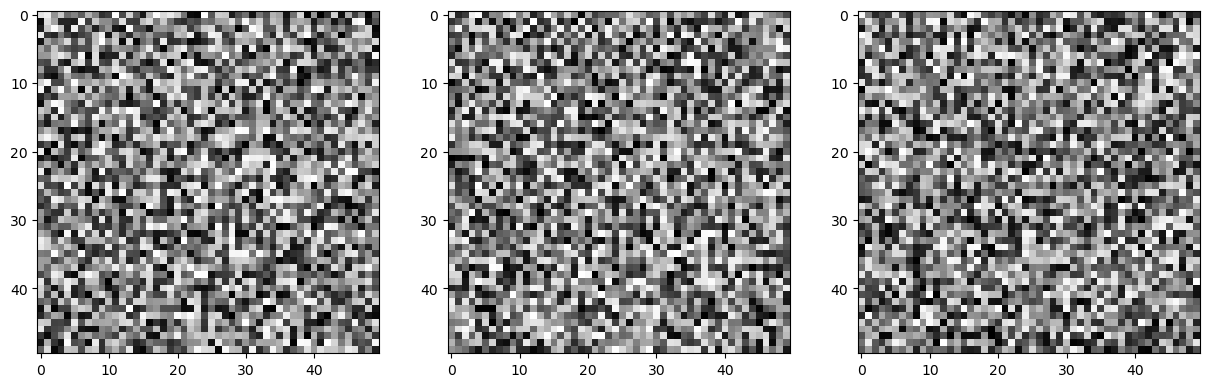

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `block` is your 3D numpy array
block = np.random.rand(3, 3, 3)  # Example data

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display slices of the block
axs[0].imshow(block[0, :, :], cmap='gray')  # Middle slice on the x-axis
axs[1].imshow(block[:, 0, :], cmap='gray')  # Middle slice on the y-axis
axs[2].imshow(block[:, :, 0], cmap='gray')  # Middle slice on the z-axis

plt.show()


In [50]:

# from mayavi import mlab
# import numpy as np

# block = np.random.rand(3, 3, 3)  # Example 3D data

# # Visualize the 3D block as a volume
# mlab.contour3d(block)
# mlab.show()
from mayavi import mlab
import numpy as np

# Create a 3x3x3 block of random data
block = np.random.rand(3, 3, 3)

# Create a figure
fig = mlab.figure(bgcolor=(1, 1, 1))

# Plot the scalar field using points
# Here 'mode' can be 'cube', 'sphere', etc.
# 'scale_factor' determines the size of the points
pts = mlab.points3d(block, mode='cube', scale_factor=0.5)

# Alternatively, if you want to use contours and your data is suitable:
mlab.contour3d(block)

# Show the visualization
mlab.show()



In [36]:
!pip install plotly
import plotly.graph_objects as go
import numpy as np

# Generate some example data
x, y, z = np.random.rand(3, 100) * 100  # 100 random points in 3D space

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
fig.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 12.4 MB/s eta 0:00:0000:0100:01


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed